In [15]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import product

In [16]:
import warnings
warnings.filterwarnings('ignore')

# Import data

In [17]:
adata_ctrl = sc.read_h5ad('anndata-objects/control.h5ad')
adata_enz = sc.read_h5ad('anndata-objects/enz.h5ad')
adata_enztaz = sc.read_h5ad('anndata-objects/enztaz.h5ad')

# Utility functions

In [18]:
def get_top_genes(adata, cluster, top_n=100):
    return adata.uns['rank_genes_groups']['names'][cluster][:top_n]

def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(set(list2)))
    union = len(set(list1).union(set(list2)))
    return intersection / union

def percentage_overlap(list1, list2):
    intersection = len(set(list1).intersection(set(list2)))
    smaller_set_size = min(len(set(list1)), len(set(list2)))
    return (intersection / smaller_set_size) * 100

In [19]:
def get_similarity_matrix(list1, list2):
    clusters_A = list1.obs['louvain'].unique()
    clusters_B = list2.obs['louvain'].unique()
    similarity_matrix = pd.DataFrame(index=clusters_A, columns=clusters_B)
    
    # Fill the matrix with Jaccard similarity scores
    for cluster_A in clusters_A:
        for cluster_B in clusters_B:
            top_genes_A = get_top_genes(list1, cluster_A)
            top_genes_B = get_top_genes(list2, cluster_B)
            similarity_matrix.loc[cluster_A, cluster_B] = jaccard_similarity(top_genes_A, top_genes_B)

    return similarity_matrix

In [20]:
def plot_similarity_matrix(similarity_matrix, x_label, y_label):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(similarity_matrix.astype(float), annot=True, cmap='viridis')
    
    # Set axis labels
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    
    # Set tick labels if needed (optional, they should already be visible)
    ax.set_xticklabels(similarity_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(similarity_matrix.index, rotation=0)
    
    # Set the plot title
    plt.title('Cluster Similarity Matrix', fontsize=14)
    
    # Display the plot
    plt.show()

# Cluster Maps

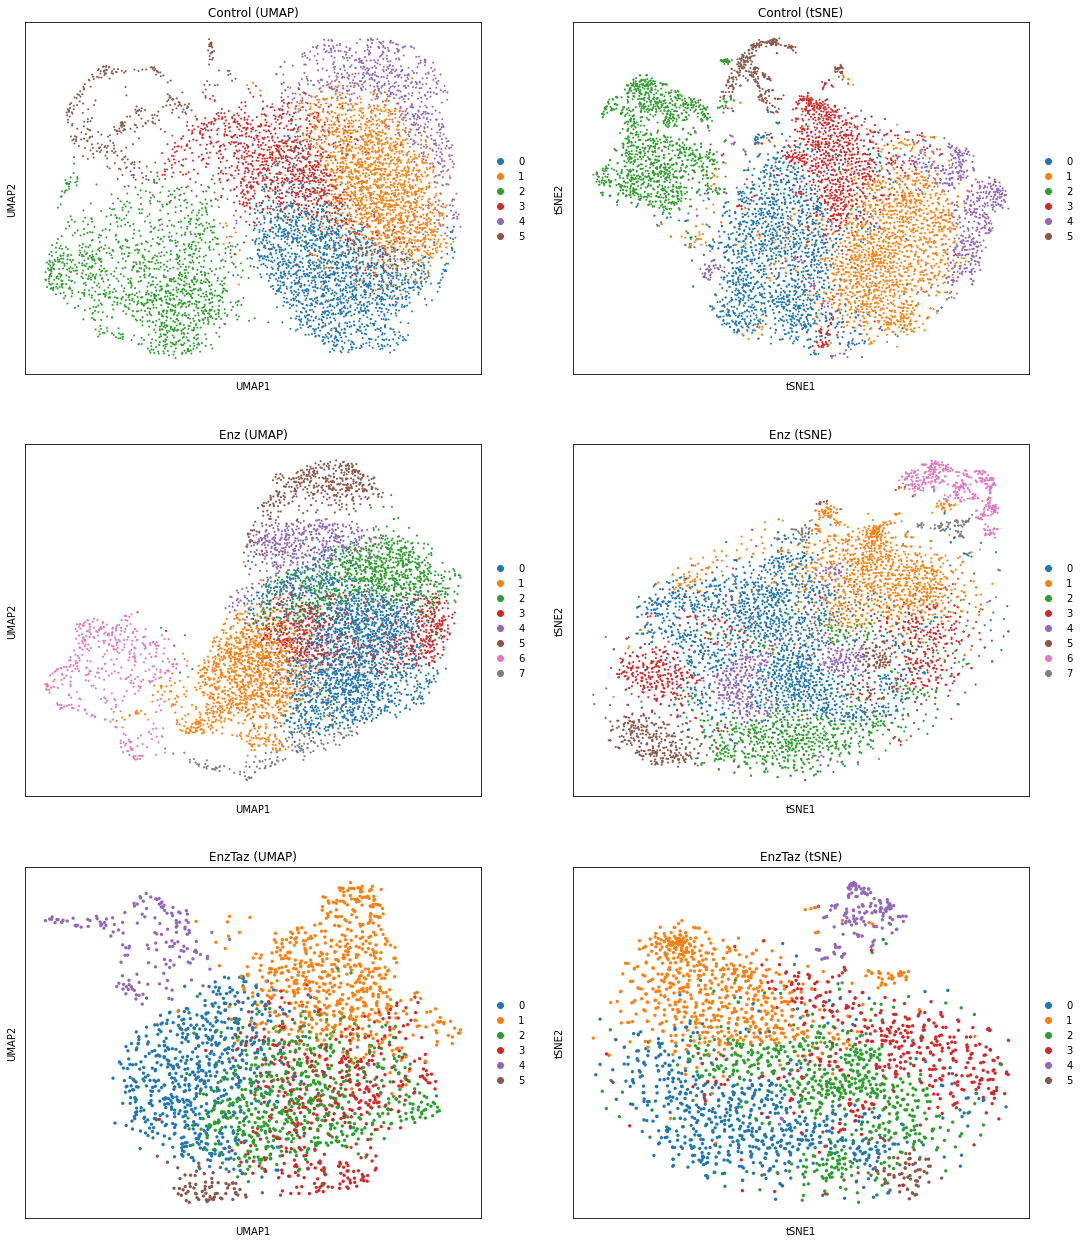

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(18, 22))

sc.pl.embedding(
    adata_ctrl,
    basis='umap',  
    color=['louvain'],
    gene_symbols='Symbol',
    title='Control (UMAP)',
    use_raw=False,
    ax=axes[0, 0], 
    show=False 
)

sc.pl.embedding(
    adata_ctrl,
    basis='tsne',  
    color=['louvain'],
    gene_symbols='Symbol',
    title='Control (tSNE)',
    use_raw=False,
    ax=axes[0, 1], 
    show=False  
)

sc.pl.embedding(
    adata_enz,
    basis='umap',  
    color=['louvain'],
    gene_symbols='Symbol',
    title='Enz (UMAP)',
    use_raw=False,
    ax=axes[1, 0], 
    show=False
)

sc.pl.embedding(
    adata_enz,
    basis='tsne',  
    color=['louvain'],
    gene_symbols='Symbol',
    title='Enz (tSNE)',
    use_raw=False,
    ax=axes[1, 1], 
    show=False
)

sc.pl.embedding(
    adata_enztaz,
    basis='umap',  
    color=['louvain'],
    gene_symbols='Symbol',
    title='EnzTaz (UMAP)',
    use_raw=False,
    ax=axes[2, 0], 
    show=False
)

sc.pl.embedding(
    adata_enztaz,
    basis='tsne',  
    color=['louvain'],
    gene_symbols='Symbol',
    title='EnzTaz (tSNE)',
    use_raw=False,
    ax=axes[2, 1], 
    show=False
)

plt.show()

# Compare Control to Enz

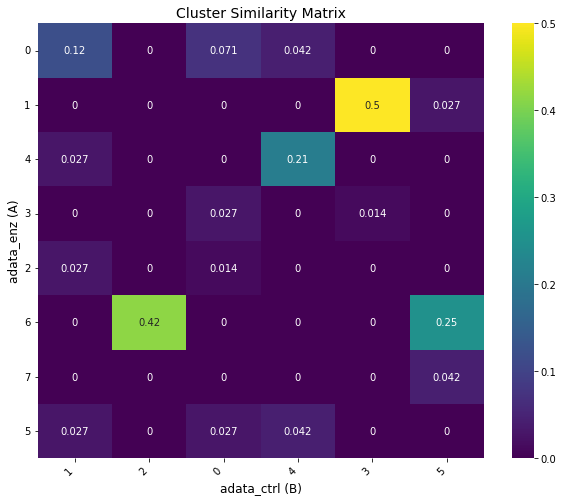

In [22]:
similarity_matrix = get_similarity_matrix(adata_enz, adata_ctrl)

plot_similarity_matrix(similarity_matrix, 'adata_ctrl (B)', 'adata_enz (A)')

# Compare Control to EnzTaz

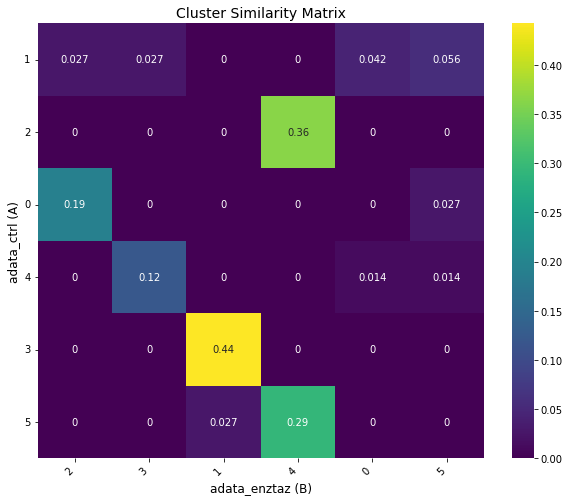

In [23]:
similarity_matrix = get_similarity_matrix(adata_ctrl, adata_enztaz)

plot_similarity_matrix(similarity_matrix, 'adata_enztaz (B)', 'adata_ctrl (A)')

# Compare Enz to EnzTaz

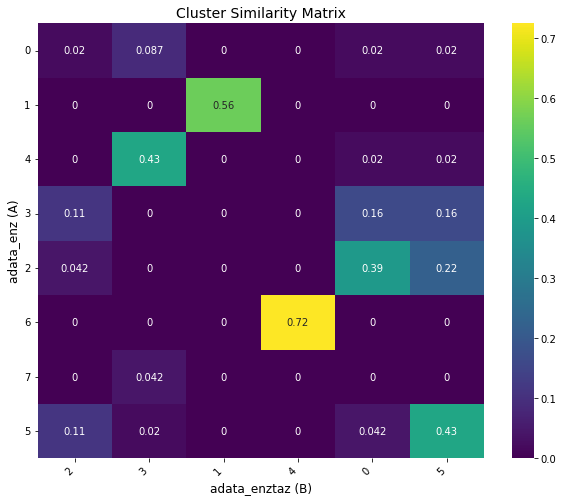

In [24]:
similarity_matrix = get_similarity_matrix(adata_enz, adata_enztaz)

plot_similarity_matrix(similarity_matrix, 'adata_enztaz (B)', 'adata_enz (A)')

# Plot Combined Heatmaps

In [25]:
def plot_similarity_matrix(similarity_matrix, x_label, y_label, ax, cbar_ax=None, show_cbar=True):
    sns.heatmap(
        similarity_matrix.astype(float),
        annot=True,
        cmap='viridis',
        cbar=show_cbar,
        cbar_ax=cbar_ax,
        ax=ax,
    )
    
    # Set axis labels
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    
    # Set tick labels
    ax.set_xticklabels(similarity_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(similarity_matrix.index, rotation=0)
    
    # Set title (optional)
    ax.set_title('Cluster Similarity Matrix', fontsize=14)


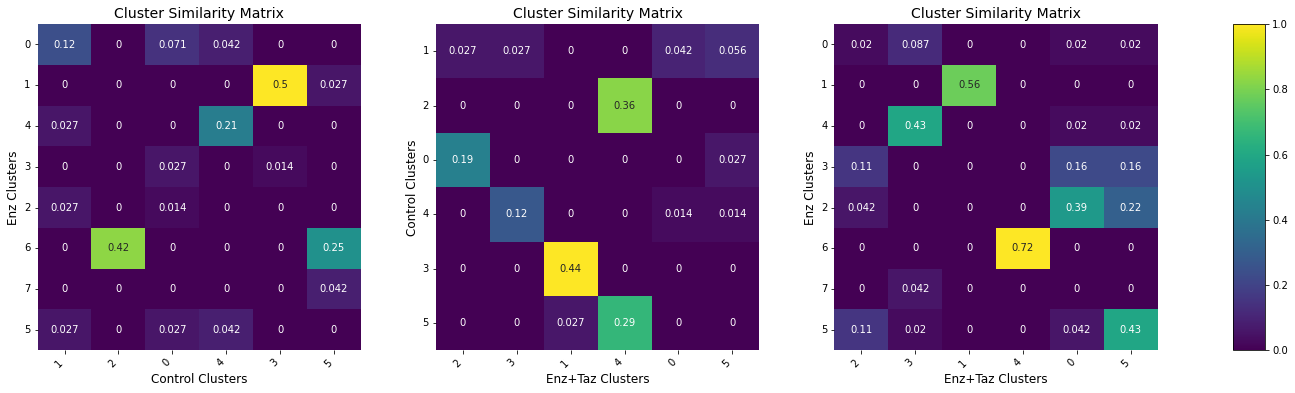

In [29]:
# Compute similarity matrices
matrix1 = get_similarity_matrix(adata_enz, adata_ctrl)
matrix2 = get_similarity_matrix(adata_ctrl, adata_enztaz)
matrix3 = get_similarity_matrix(adata_enz, adata_enztaz)

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(22, 6))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.1], wspace=0.3)

# Create individual axes for heatmaps and a shared axis for the colorbar
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
cbar_ax = fig.add_subplot(gs[3])

# Plot each similarity matrix
plot_similarity_matrix(matrix1, 'Control Clusters', 'Enz Clusters', ax1, cbar_ax=cbar_ax, show_cbar=False)
plot_similarity_matrix(matrix2, 'Enz+Taz Clusters', 'Control Clusters', ax2, cbar_ax=None, show_cbar=False)
plot_similarity_matrix(matrix3, 'Enz+Taz Clusters', 'Enz Clusters', ax3, cbar_ax=None, show_cbar=False)

# Add a colorbar to the shared colorbar axis
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

# Display the plot
plt.show()

fig.savefig('sim_matrix.png', dpi=200)